In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

# 1. Dataset

In [2]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
labels_tr = train['label']
images_tr = train.drop(columns=['label'])

In [4]:
images_arr_tr = np.array(images_tr).reshape(images_tr.shape[0], 28, 28)
images_arr_ts = np.array(test).reshape(test.shape[0], 28, 28)

In [5]:
images_arr_tr.shape, images_arr_ts.shape

((42000, 28, 28), (28000, 28, 28))

In [6]:
images_arr_tr[0].shape

(28, 28)

### Showing some of the images

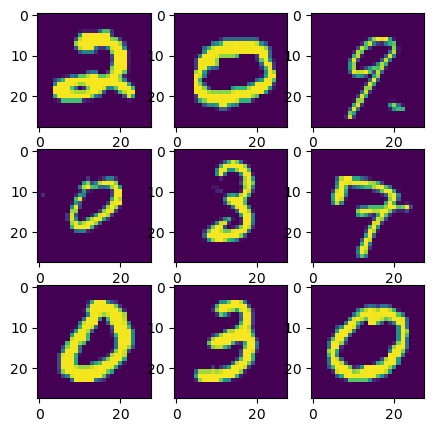

In [7]:
def show_images(images, n):
    rows = int(np.floor(np.sqrt(n)))
    cols = n // rows
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    count = 0
    for i in range(rows):
        for j in range(cols):
            axes[i][j].imshow(images[count])
            count += 1

show_images(images_arr_ts, n=10)

### Save Numpy array dataset into directories(format=".npy")

In [8]:
labels = list(set(labels_tr))

In [9]:
train_path = Path('./data/train')
test_path = Path('./data/test')
val_path = Path('./data/val')

In [10]:
all_images = [(labels_tr[i], images_arr_tr[i]) for i in range(len(labels_tr))]

In [11]:
random_data = random.shuffle(all_images)
train_size = 0.95 * len(all_images)

In [12]:
# Train and Validation set
for i, (label, image_arr) in enumerate(all_images):
    if i < train_size:
        image_path = train_path/str(label)
    else: 
        image_path = val_path/str(label)
    
    image_path.mkdir(parents=True, exist_ok=True)
    np.save(image_path/str(i), image_arr)

In [13]:
# Test set
for i, image_arr in enumerate(images_arr_ts):
    test_path.mkdir(parents=True, exist_ok=True)
    np.save(test_path/str(i), image_arr)

In [14]:
class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        self.file_list = []
        
        for folder in os.listdir(self.root_dir):
            sub_path = os.path.join(self.root_dir, folder)
            
            if "test" in self.root_dir:
                self.file_list.append((sub_path, 0))
            else:
                for file in os.listdir(sub_path):
                    file_path = os.path.join(sub_path, file)
                    self.file_list.append((file_path, int(folder)))
        
    def __len__(self):
        return len(self.file_list)
        
    def __getitem__(self, idx):
        item = self.file_list[idx]
        data = np.load(item[0])

        if self.transform:
            data = self.transform(data.astype(np.float32))
                
        if 'test' in item[0]:
            return data
        else:
            return data, item[1]

In [15]:
from torchvision.transforms import ToTensor, Normalize, RandomRotation, RandomAffine, RandomCrop
import torchvision.transforms as T

mean = 0.5
std = 0.5

tsms = T.Compose([
    ToTensor(),
    Normalize((mean,), (std,))
])


# Define the transformations
train_tsms = T.Compose([
    ToTensor(),
    RandomRotation(10),
    RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    Normalize((mean,), (std,))
])


In [16]:
train_dataset = MNISTDataset('./data/train', transform=train_tsms)
val_dataset = MNISTDataset('./data/val', transform=tsms)
test_dataset = MNISTDataset('./data/test', transform=tsms)

In [17]:
batch_size = 256

# Pytorch data loaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

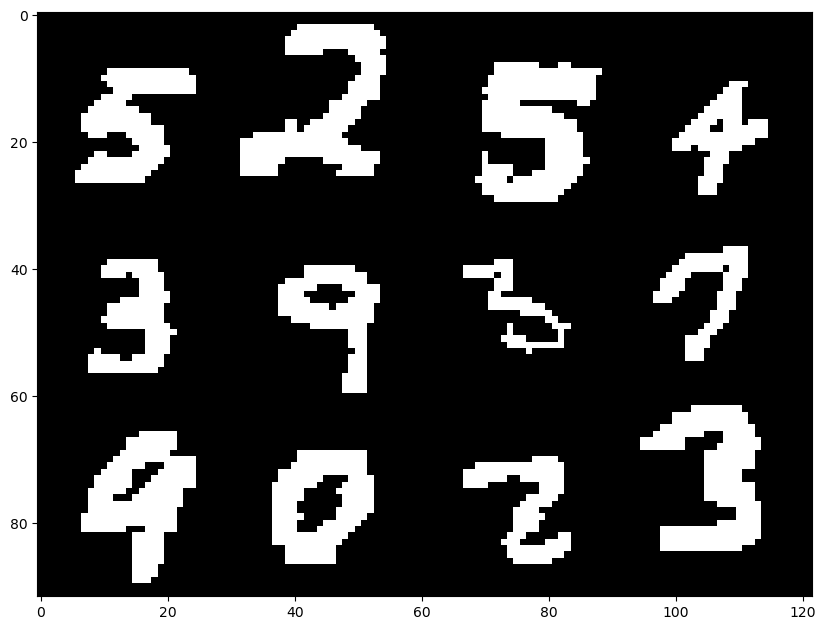

In [18]:
from torchvision.utils import make_grid

def show_batch(dl):
    for i, (images, labels) in enumerate(dl):
        if i == 10:
            break
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(make_grid(images[:12], 4).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# Model Creation

In [19]:
import torch.nn as nn

def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), nn.ReLU(inplace=True), conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
            
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [20]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()
        layers = [conv_2d(1, n_start)]
        n_channels = [n_start]
        for i in range(n_groups):
            n_channels.append(n_start * (2**i) * k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], n_channels[i+1], stride)
        layers += [
            nn.BatchNorm2d(n_channels[3]),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(n_channels[3], n_classes)
        ]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.features(x)

In [21]:
def wrn_22():
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [22]:
model = wrn_22()
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# Model Training

In [23]:
from fastai.metrics import accuracy
from fastai.vision.all import *

In [24]:
learn = Learner(DataLoaders(train_dl, val_dl), model, metrics=accuracy, loss_func=F.cross_entropy)

SuggestedLRs(valley=0.0012022644514217973)

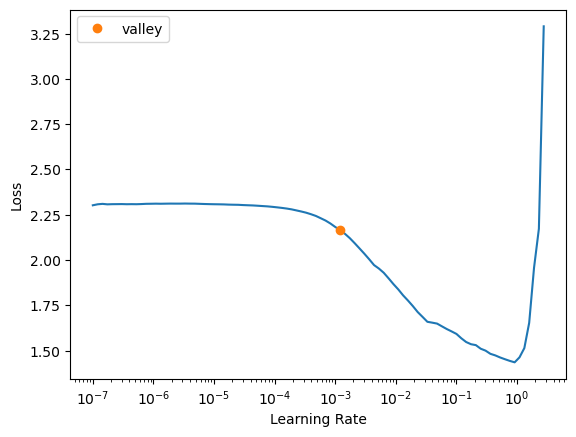

In [25]:
learn.clip = 0.1
learn.lr_find()

In [26]:
learn.fit_one_cycle(n_epoch=15, lr_max=0.001, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.854083,0.255718,0.940952,00:50
1,0.139803,0.087462,0.975238,00:50
2,0.079419,0.493773,0.869048,00:51
3,0.065308,0.084146,0.973810,00:52
4,0.054247,0.047060,0.988095,00:50
5,0.047920,0.035967,0.989524,00:51
6,0.040441,0.026950,0.989524,00:49
7,0.034103,0.028888,0.990476,00:50
8,0.032447,0.016047,0.993810,00:50
9,0.025469,0.015831,0.995238,00:50


# Prediction and Submission

In [27]:
test_dl = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [28]:
predictions = []

for images in test_dl:
    images = images.to('cuda')
    output = model(images)
    _, predicted = torch.max(output, 1)
    predictions.extend(predicted.tolist())

In [29]:
tst_dirs = os.listdir('./data/test')
tst_data = [(tst_dirs[i], predictions[i]) for i in range(len(predictions))]

In [30]:
tst_data = sorted(tst_data, key=lambda x: int(re.findall(r'\d+', x[0])[0]))

In [31]:
preds = [item[1] for item in tst_data]
preds[:10]

[2, 0, 9, 0, 3, 7, 0, 3, 0, 3]

In [32]:
sub_df = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
sub_df['Label'] = preds
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
